In [1]:
%load_ext autoreload
%autoreload 2

# SIR model

Here we calibrate a differentiable version of the SIR model.
We use the exact same model as  https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html,
but implemented in a differentiable way.

In [2]:
from birds.models.sir import SIR
from birds.calibrator import Calibrator

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import normflows as nf
from corner import corner # to plot corner plots

## Generating synthetic true data

In [3]:
# generate a random graph
n_agents = 1000
graph = networkx.watts_strogatz_graph(n_agents, 10, 0.1)

In [4]:
sir = SIR(graph, n_timesteps=100)

In [5]:
%%time
# the simulator takes as parameters the log10 of the fraction of initial cases, beta, and gamma parameters
true_parameters = torch.log10(torch.tensor([0.05, 0.05, 0.05]))
true_data = sir.observe(sir.run(true_parameters))
true_infected, true_recovered = true_data

CPU times: user 55.1 ms, sys: 33 ms, total: 88.2 ms
Wall time: 62.3 ms


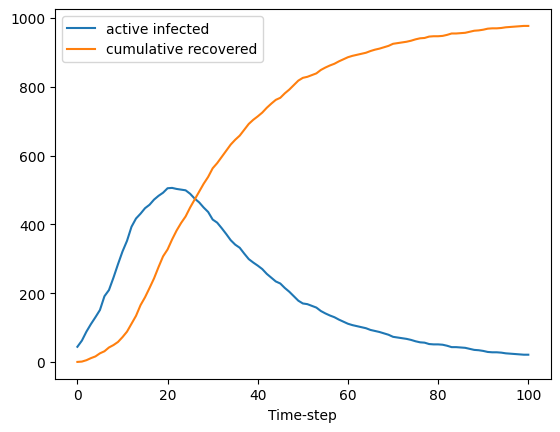

In [6]:
f, ax = plt.subplots()
ax.plot(true_infected, label = "active infected")
ax.set_xlabel("Time-step")
ax.plot(true_recovered, label = "cumulative recovered")
ax.legend()

## Approximating the posterior by a normalizing flow

We construct the flow using the normflows library (https://github.com/VincentStimper/normalizing-flows )

In this case we define Neural Spline Flow with 4 transformations, each parametrised by 2 layers with 64 hidden units.

In [7]:
# Define flows
K = 4
torch.manual_seed(0)

latent_size = 3
hidden_units = 64
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set prior and q0
q0 = nf.distributions.DiagGaussian(3, trainable=False)
    
# Construct flow model
flow = nf.NormalizingFlow(q0=q0, flows=flows)


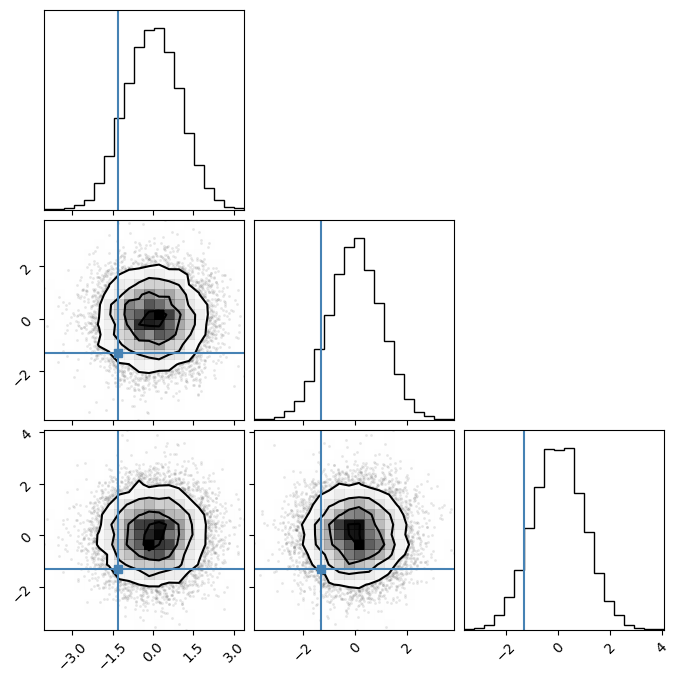

In [8]:
# Plot the inital flow:
samples = flow.sample(10000)[0].detach().numpy()

corner(samples, truths=true_parameters.numpy());

Let's also plot runs sampled from the untrained flow, to compare later with the trained flow.

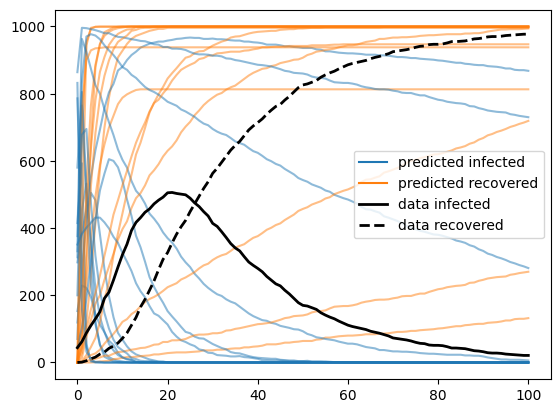

In [9]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(15):
    with torch.no_grad():
        sim_sir = sir.observe(sir.run(flow.sample(1)[0][0]))
    ax.plot(sim_sir[0].numpy(), color = "C0", alpha=0.5)
    ax.plot(sim_sir[1].numpy(), color = "C1", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted infected")
ax.plot([], [], color = "C1", label = "predicted recovered")
ax.plot(true_data[0], color = "black", linewidth=2, label = "data infected")
ax.plot(true_data[1], color = "black", linewidth=2, label = "data recovered", linestyle="--")

ax.legend()

### Train the flow

In [12]:
torch.manual_seed(0)

# Define a prior
prior = torch.distributions.MultivariateNormal(-2.0 * torch.ones(3), torch.eye(3))

optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)

# We set the regularisation weight to 10.
w = 10

# Note that we can track the progress of the training by using tensorboard.
# tensorboard --logdir=runs
log_dir = "./runs/sir_run"

calibrator = Calibrator(model = sir, posterior_estimator = flow, prior=prior, data=true_data, optimizer=optimizer, w=w, tensorboard_log_dir=log_dir)

# and we run for 500 epochs without early stopping.

calibrator.run(n_epochs=500, max_epochs_without_improvement=np.inf);

  0%|                                                                                                                                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]

torch.Size([3, 1000])


IndexError: too many indices for tensor of dimension 2

<Axes: >

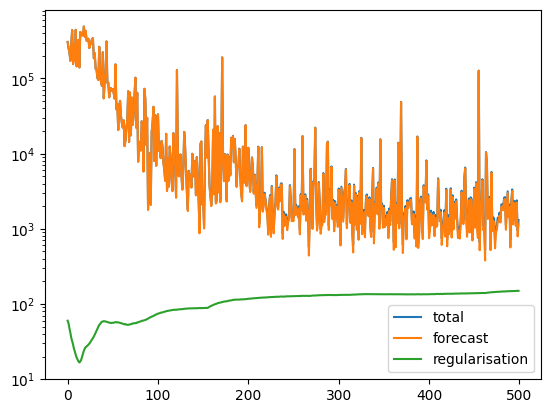

In [10]:
# Let's have a look at the loss over epochs:

df = pd.DataFrame(calibrator.losses_hist)
df.plot(logy=True)

In [14]:
# We can load the best model to check the results
flow.load_state_dict(calibrator.best_model_state_dict)

<All keys matched successfully>

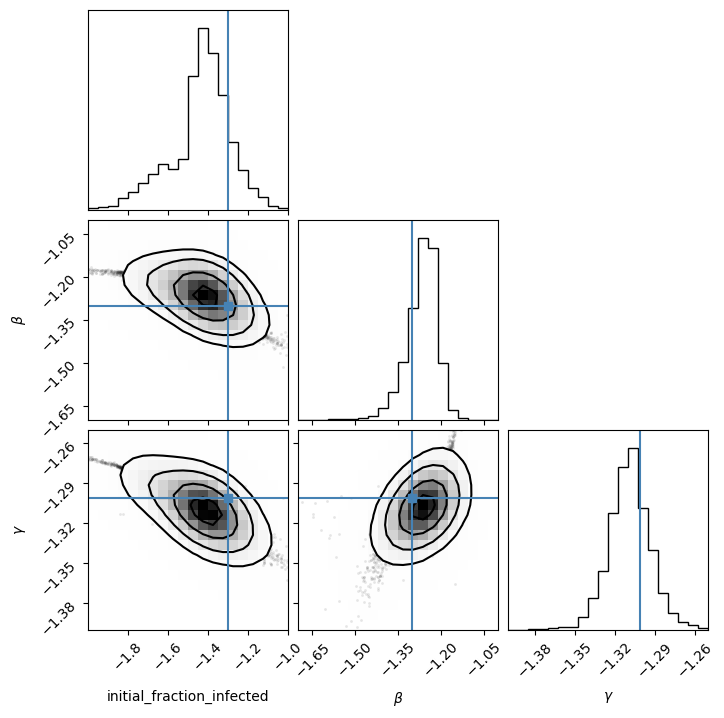

In [28]:
# Plot the final flow posterior approximator and compare it to the real parameters:
samples = flow.sample(10000)[0].detach().numpy()

corner(samples, truths=true_parameters.numpy(), smooth=2, range = ((-2, -1.0), (-1.7, -1.0), (-1.4, -1.25)), labels=["initial_fraction_infected", r"$\beta$", r"$\gamma$"]);

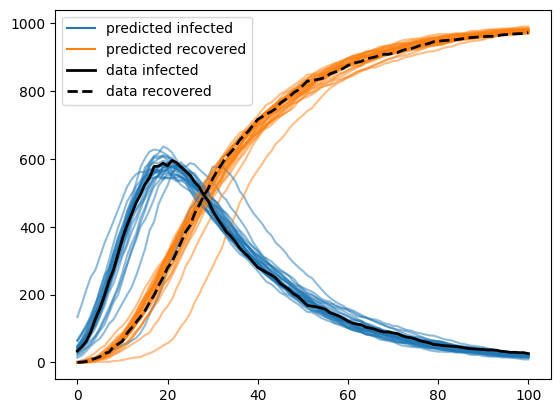

In [29]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(25):
    with torch.no_grad():
        sim_sir = sir(flow.sample(1)[0][0])
    ax.plot(sim_sir[0].numpy(), color = "C0", alpha=0.5)
    ax.plot(sim_sir[1].numpy(), color = "C1", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted infected")
ax.plot([], [], color = "C1", label = "predicted recovered")
ax.plot(true_data[0], color = "black", linewidth=2, label = "data infected")
ax.plot(true_data[1], color = "black", linewidth=2, label = "data recovered", linestyle="--")

ax.legend()